In [2]:
import os
import sys
sys.path.insert(0, '../PYTHON/HLB')
import orange_canopy as orca

from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

from imgaug import augmenters as iaa

import numpy as np

import skimage

logs = '../Mask_RCNN/logs'
dataset = '../Mask_RCNN/datasets/canopy'

... done downloading pretrained model!


## Treinamento

In [18]:
config = orca.OrangeCanopyConfig()
# config.display()

In [3]:
weights = '../Mask_RCNN/mask_rcnn_coco.h5'
# weights = '../Mask_RCNN/logs/trees.h5'

In [4]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=logs)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [5]:
model.load_weights(weights, 
                   by_name=True,
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

In [16]:
train_dataset = orca.OrangeCanopyDataset()
train_dataset.load_data(dataset, 'train')
train_dataset.prepare()

val_dataset = orca.OrangeCanopyDataset()
val_dataset.load_data(dataset, 'val')
val_dataset.prepare()

augmentation = iaa.SomeOf((0, 2), [iaa.Fliplr(0.5), iaa.Flipud(0.5), iaa.OneOf([iaa.Affine(rotate=90), iaa.Affine(rotate=180), iaa.Affine(rotate=270)]), iaa.Multiply((0.5, 1.5))])

In [ ]:
model.train(train_dataset, val_dataset,
            learning_rate=config.LEARNING_RATE,
            epochs=4,
            augmentation=augmentation,
            layers='heads')


Starting at epoch 0. LR=0.0002

Checkpoint Path: ../Mask_RCNN/logs/oranges_trees_canopy20210803T1653/mask_rcnn_oranges_trees_canopy_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
m

/home/user/anaconda3/envs/rcnn/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/4


/home/user/anaconda3/envs/rcnn/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/home/user/anaconda3/envs/rcnn/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub_1:0", shape=(None,), dtype=int32), values=Tensor("train

286/500 [================>.............] - ETA: 27:07 - batch: 142.5000 - size: 1.0000 - loss: 5.2168 - rpn_class_loss: 0.3220 - rpn_bbox_loss: 3.8942 - mrcnn_class_loss: 0.1600 - mrcnn_bbox_loss: 0.4433 - mrcnn_mask_loss: 0.3974

# Inferência

In [9]:
class InferenceConfig(orca.OrangeCanopyConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    # I kept the same configuration of the training
    NUM_CLASSES = 1 + 1
    NAME = 'trees'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    BACKBONE = "resnet50"
    DETECTION_MIN_CONFIDENCE = 0.5
    BACKBONE_STRIDES = [4, 8, 16, 32, 64]
    RPN_ANCHOR_SCALES = (4, 8, 16, 32, 64)
    USE_MINI_MASK = False
    IMAGE_CHANNEL_COUNT = 3
    RPN_NMS_THRESHOLD = 0.9
    MEAN_PIXEL = np.array([105, 236, 189])
    DETECTION_NMS_THRESHOLD = 0.3
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    MAX_GT_INSTANCES = 100
    DETECTION_MAX_INSTANCES = 100
    TRAIN_ROIS_PER_IMAGE = 100
    RPN_TRAIN_ANCHORS_PER_IMAGE = 100
    
config = InferenceConfig()

In [10]:
model = modellib.MaskRCNN(mode='inference', config=config, model_dir=logs)

In [11]:
weights = '../Mask_RCNN/logs/oranges_trees_canopy20210803T1653/mask_rcnn_oranges_trees_canopy_0012.h5'

model.load_weights(weights, by_name=True)

Re-starting from epoch 12


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -217.00000  max:  150.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32


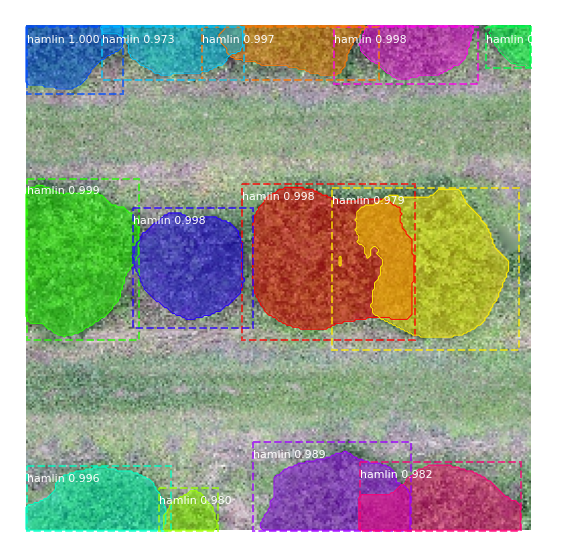

In [21]:
images_test_dir = os.path.join(dataset, 'real_test', 'images')
# images_test_dir = '../IMGS'

image_paths = []
for filename in os.listdir(images_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(images_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)

    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'],
                                val_dataset.class_names, r['scores'], figsize=(10, 10))
    break

In [ ]:
visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'],
                                val_dataset.class_names, r['scores'], figsize=(15, 15))